Manuela & Sebastian <br>
Site Remediation CIVE686 <br>

**Objective**

The main objective of this report is exploring how can bioremediation (air sparging) be used on the Elizabeth City, NC site to clean up the concentration of TCE while tracking the degradation products and microbial growth.

**Assumptions**
- We are assuming that the maximum depth the TCE has reached is 35m as below that depth there is bedrock.
- Assuming no sorption given that there is just sand which is composed mainly by silica and the organic matter can be negligible.
- The concentration after the barrier should be 10$\%$ of the initial concentration.

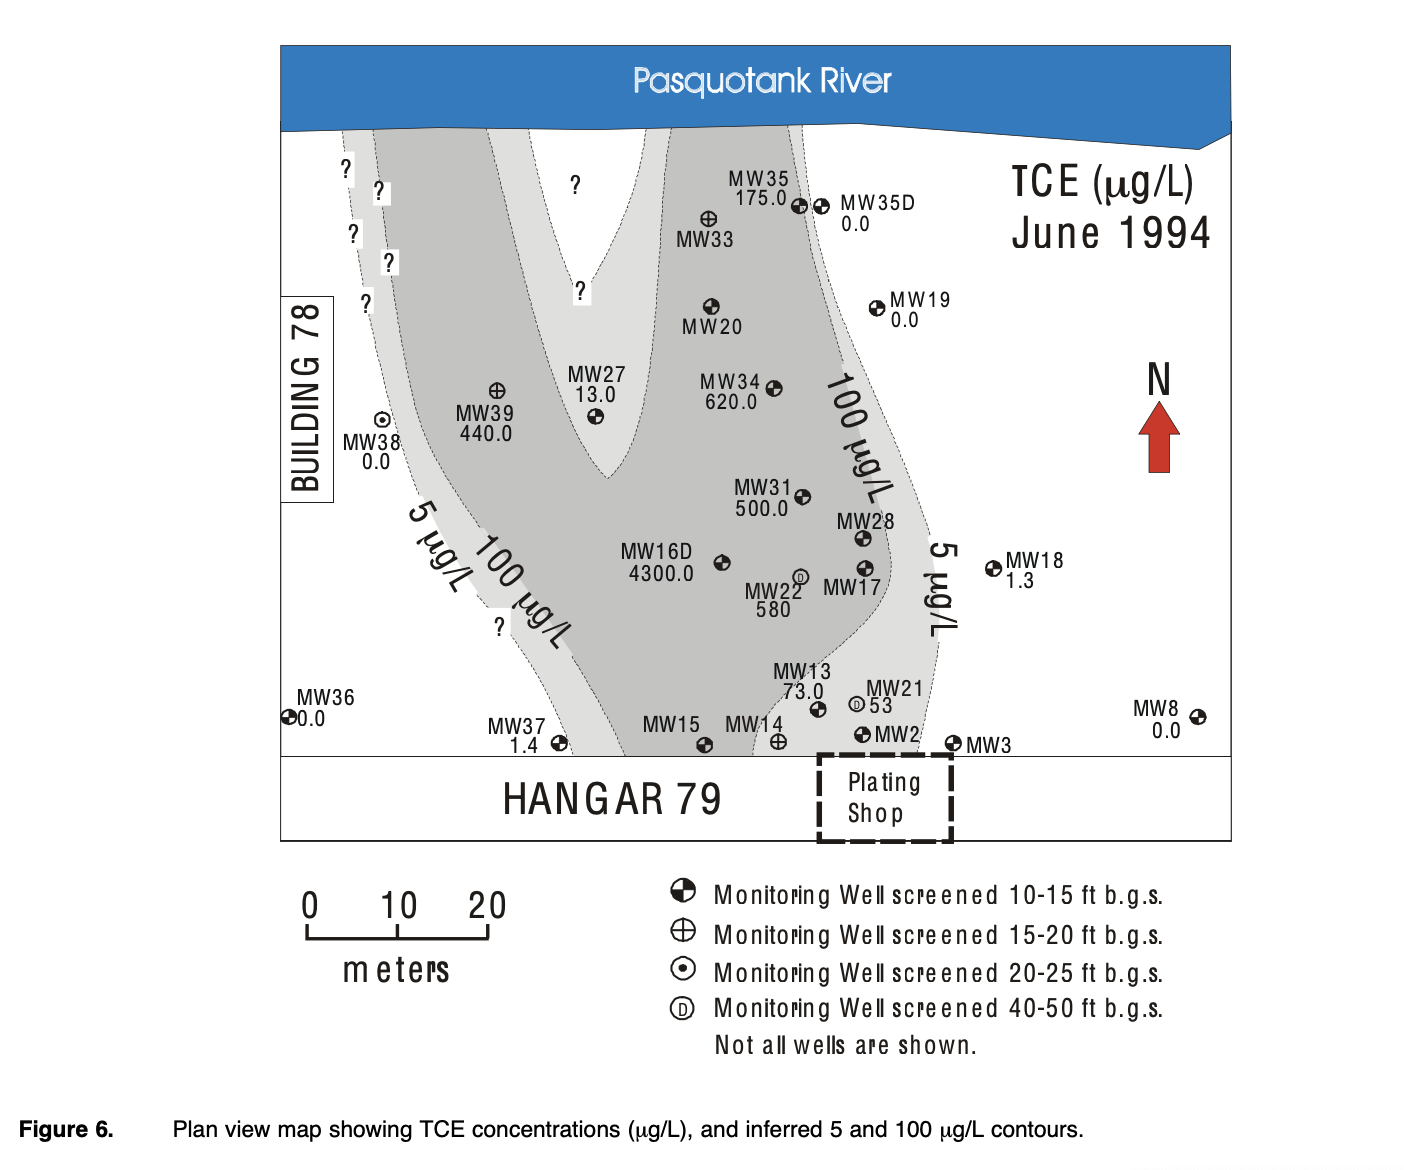
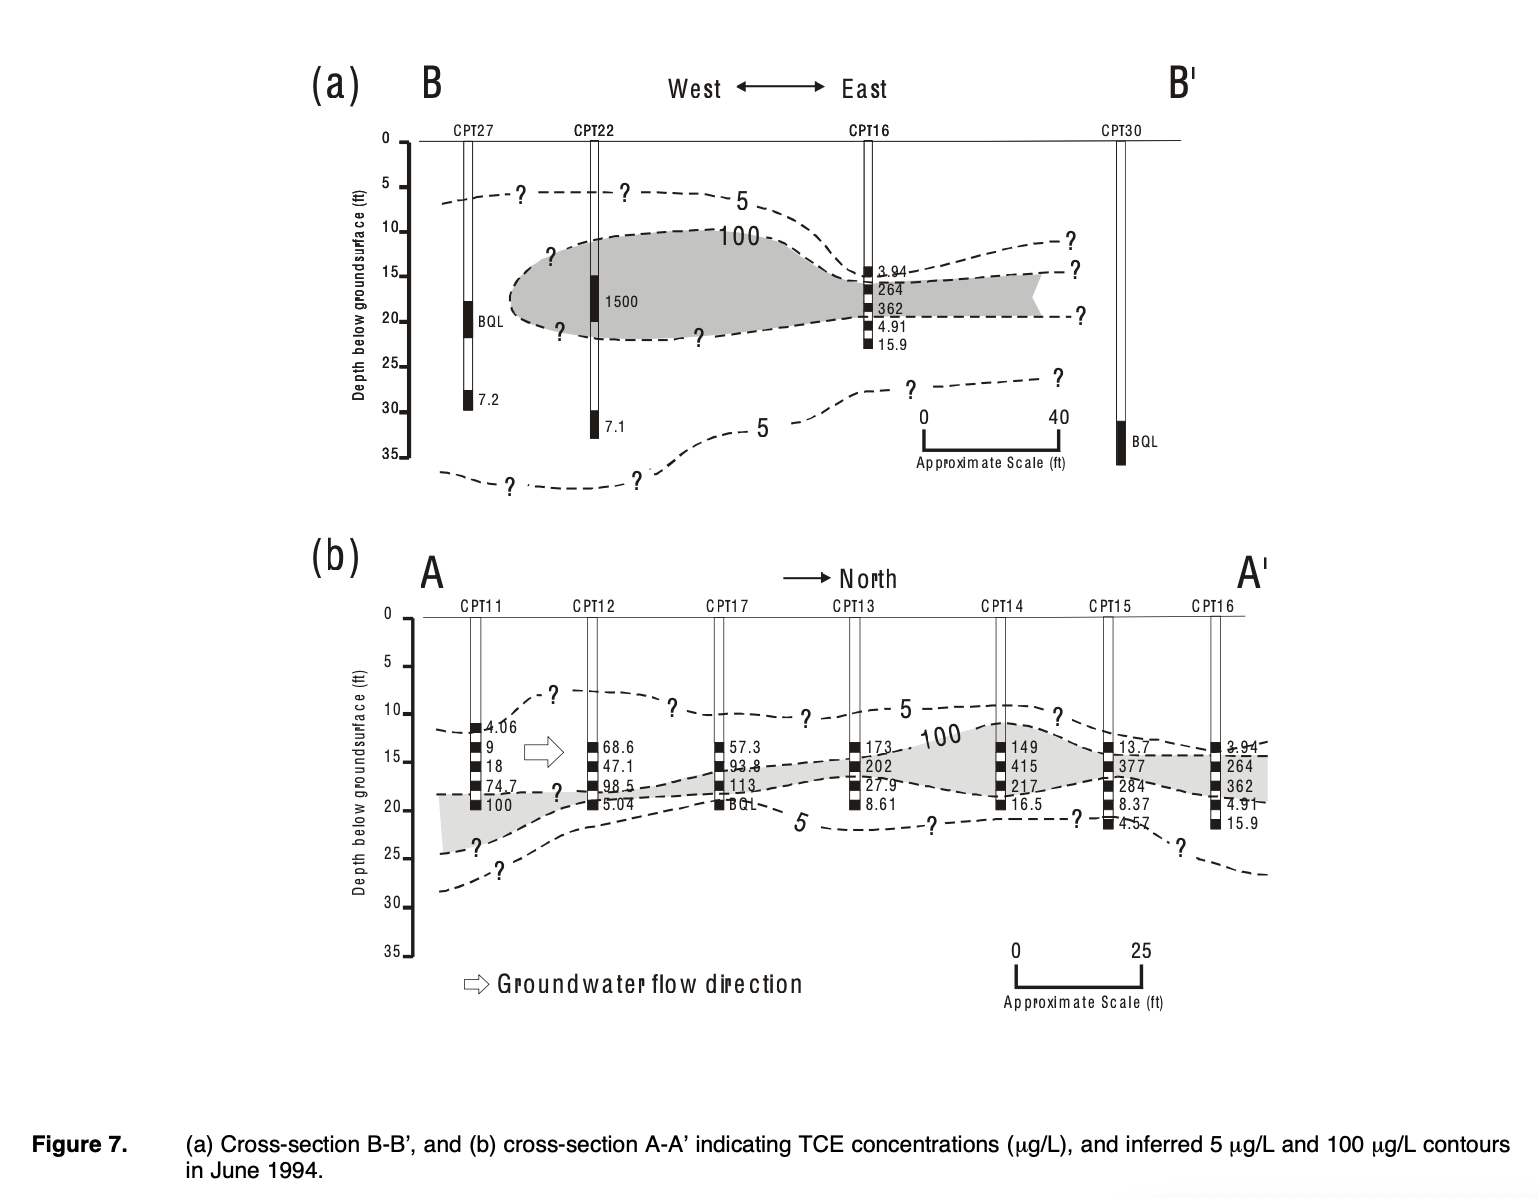
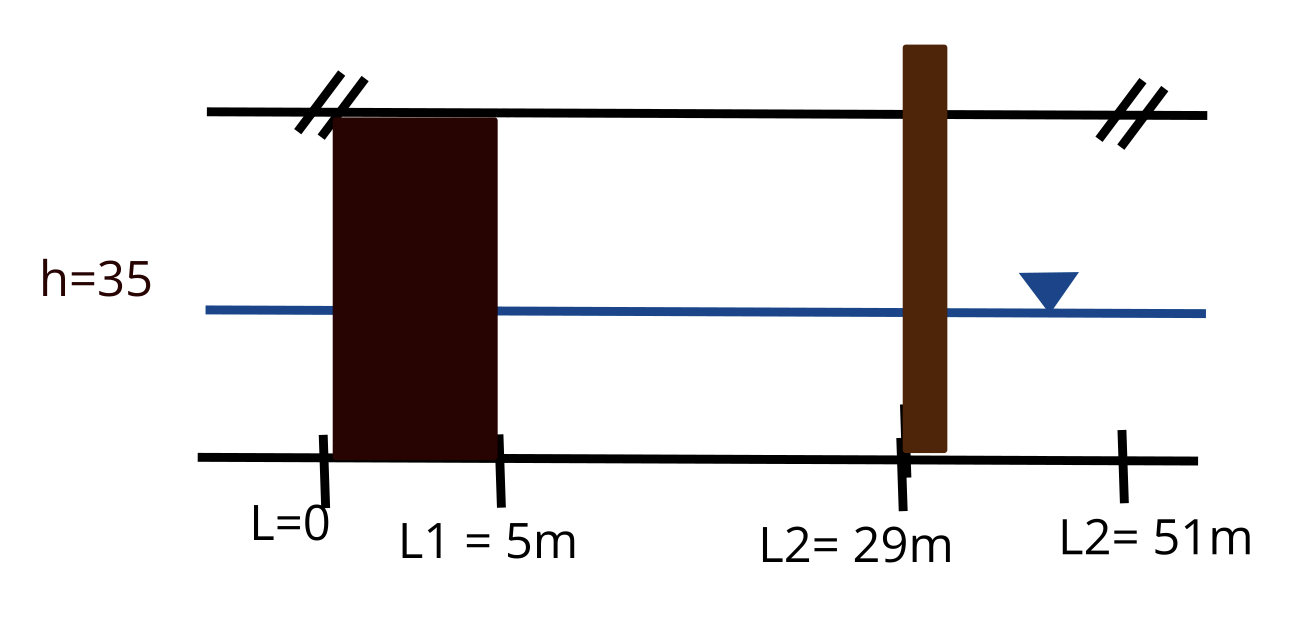

Main equation from L=0 to L=5m
$$    \frac{d C}{dt} = -v_x \frac{dC}{dx} + D_x \frac{d^2C}{dx^2} + k \frac{A}{V} (C_eq - C) $$
Consider the mass depleted from NAPL in $\triangle t$
$$ \frac{dM}{dt} = V \cdot \frac{dC}{dt} = v_{air} \frac{K_i A}{v} (C_eq - C)$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
num_wells = 1
L1 = 5 #5m
L2 = 29 #m
L3 = 51 #m
# consider a grid with 
delta_x = 0.25 #m  one grid pont each delta_x meters
delta_t = 10 # one time step each delta_t seconds
num_lines_depth = 35 # basically in how many strips I want to split the 
# whole area
k_micro = 4e-3 # would be the same as k1

# How long do you want to run it?
total_time = 3600*24*1 # let's try total_time seconds

total_grid_points = int(np.ceil(L3//delta_x))
total_time_points = int(np.ceil(total_time//delta_t))
# using the 1D contaminant approach
tce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of DCE
dce_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of VC
vc_mat= np.zeros(( total_grid_points, total_time_points))

# Mass matrix
tce_mass_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of DCE
dce_mass_mat = np.zeros(( total_grid_points, total_time_points))
# Matrix of VC
vc_mass_mat= np.zeros(( total_grid_points, total_time_points))



# set some boundary conditions, we are assuming an initial concentration of 100mu g/L
co_TCE = 100 *(1/1000) # mg/L 


# Matrix of TCE
tce_mat[:, 0] = co_TCE

depth = 35

b  = 1# width of site we can do per meter
n = 0.4# porosity of soil
rho_tce = 1.46 * (100)**3 * (1000)#g/cm3 -> g/m^3 -> mg/m^3
total_mass_NAPL = ((L1*b*depth)*0.4) # mg
total_mass_tce = total_mass_NAPL*rho_tce # mg

mass_per_strip = total_mass_tce / num_lines_depth
mass_per_grid_point = mass_per_strip /(L1//delta_x) 

# [0.43, 0.79]
v_x = (0.43 * (1/(24*3600))) #m/day ratio of linear travel distance and travel time
v_air = 4e-3 #m3

# set up the initial conditions of the mass of TCE
# Basically from 0 all the way to L1 at T1 I know the mass in each point
# would be 
# I added the plus one, because I will assume that at all times,
# the mass at the column 0, L_0 is going to be 0 same with L2
# that is at L1//delta_x index the mass would be zero
tce_mass_mat[:int(L1//delta_x) + 1, 0] = mass_per_grid_point


# consider the section from 0 to L1 we only have dispersion and difussion as the
# main forces displacing our contaminant TCE, which is inside of a NAPL

mol_mass_TCE = 131.4 #g/mol
aq_sol_TCE = 1.280  * (1/1000)# mg/L
k2 =  3.94e-5# first order constant of degradation

alpha = 1#m dispersivity coefficient
D_s = 10**-6# D star or difussion coefficient
Dx = alpha * v_x + D_s
ktav = 25.0 * (1/(24*3600)) # per day lumped mass transfer coefficient



def compute_dc_dt_mass(curr, prev, next, Dx, v_x, ktav):
    avg_spa = (next - prev)/(2*delta_x)
    diff = (next - 2*curr + prev)/(delta_x**2)
    return (-v_x*avg_spa + diff*Dx + ktav*(aq_sol_TCE  - curr))


def compute_dc_dt_bio(curr, prev, next,  Dx, v_x, k_spa, k_micro):
    avg_spa = (next - prev)/(2*delta_x)
    diff = (next - 2*curr + prev)/(delta_x**2)
    return (-v_x*avg_spa + diff*Dx - (k_spa + k_micro)*curr)  

def compute_dce_step(curr_tce, curr_dce):
    x = 1#mole transfet coefficient
    k1 = k_micro # first order constant of degradation
    return curr_dce + (x*k1*curr_tce - k2*curr_dce )*delta_t

def compute_vc_step(curr_dce, curr_vc):
    y = 1#mole transfet coefficient
    k3 =  1.23e-4# first order constant of degradation
    return curr_vc + (y*k2*curr_dce - k3*curr_vc )*delta_t


for t in range(total_time_points - 1):
    for i in range(total_grid_points):
        # check for boundary cases
        dis_i = i*delta_x
        if dis_i <= L1:
            if i == 0:
                tce_mat[i, t + 1] = 0 # concentration at the boundary doesn't change
                tce_mass_mat[i, t+ 1] = 0
            else:
                dc_dt =  compute_dc_dt_mass(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, ktav)  
                tce_mat[i, t + 1] =  tce_mat[i, t] + delta_t*dc_dt
                # update the mass matrix of TCE
                tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] - delta_t*(dc_dt)*v_air 

        elif dis_i < L2:
            alpha = 1#m dispersivity coefficient
            D_s = 0# D star or difussion coefficient
            Dx = alpha * v_x + D_s
            dc_dt = compute_dc_dt_mass(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, 0)
            tce_mat[i, t + 1] = tce_mat[i, t] + dc_dt*delta_t
            # update the mass matrix of TCE
            tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] - delta_t*(dc_dt)*v_air 
        else:
            alpha = 1#m dispersivity coefficient
            D_s = 0# D star or difussion coefficient
            Dx = alpha * v_x + D_s
            k_hy = 9.02e-2 # m^3 atm/mol henry constant fot TCE
            Q_air = 10^-1 # m^3/s
            k_spa = Q_air * k_hy

            # athing beyond L2
            if i == total_grid_points - 1:
                tce_mat[i , t + 1] = 0#tce_mat[i - 2, t] # anything beyond L3 repeats
                dce_mat[i, t + 1] = 0#dce_mat[i - 2, t]
                vc_mat[i, t + 1] = 0#vc_mat[i -2, t]
                tce_mass_mat[i, t + 1] = 0
            else:
                dc_dt = compute_dc_dt_bio(tce_mat[i, t], tce_mat[i -1, t], tce_mat[i+ 1, t], Dx, v_x, k_spa, k_micro)
                tce_mat[i, t + 1] = tce_mat[i, t] + dc_dt*delta_t
                tce_mass_mat[i, t + 1] = tce_mass_mat[i, t] -  dc_dt*v_air*delta_t
                dce_mat[i, t + 1] = compute_dce_step(tce_mat[i, t], dce_mat[i, t])
                vc_mat[i, t + 1] = compute_dce_step(dce_mat[i, t], vc_mat[i, t])
                
            if dis_i == L2:
                dce_mat[i, t + 1] = 0
                vc_mat[i, t + 1] = 0 
                

C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:72: RuntimeWarning: overflow encountered in scalar divide
  diff = (next - 2*curr + prev)/(delta_x**2)
C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:78: RuntimeWarning: overflow encountered in scalar divide
  diff = (next - 2*curr + prev)/(delta_x**2)
C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:135: RuntimeWarning: overflow encountered in scalar multiply
  tce_mat[i, t + 1] = tce_mat[i, t] + dc_dt*delta_t
C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:73: RuntimeWarning: invalid value encountered in scalar add
  return (-v_x*avg_spa + diff*Dx + ktav*(aq_sol_TCE  - curr))
C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:73: RuntimeWarning: invalid value encountered in scalar multiply
  return (-v_x*avg_spa + diff*Dx + ktav*(aq_sol_TCE  - curr))
C:\Users\sibarr2\AppData\Local\Temp\ipykernel_30620\4267188154.py:77: RuntimeWarning: invalid value en

c:\Programs\anaconda3\Lib\site-packages\matplotlib\ticker.py:2119: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


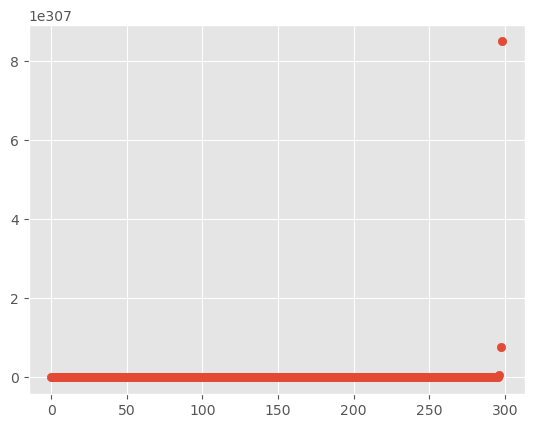

In [23]:
normalized_x = np.linspace(0, L3, total_grid_points)
plt.scatter(np.arange(total_time//delta_t), tce_mat[int(L2//delta_x), :])
#plt.scatter(np.arange(total_time//delta_t), dce_mat[int(L1//delta_x) - 2, :])
#plt.scatter(np.arange(total_time//delta_t), vc_mat[int(L1//delta_x) - 2, :])

# plot of the mass matrix of TCE
#for t in range(100):
#    plt.plot(), tce_mass_mat[:, t])
    #plt
#    plt.show()

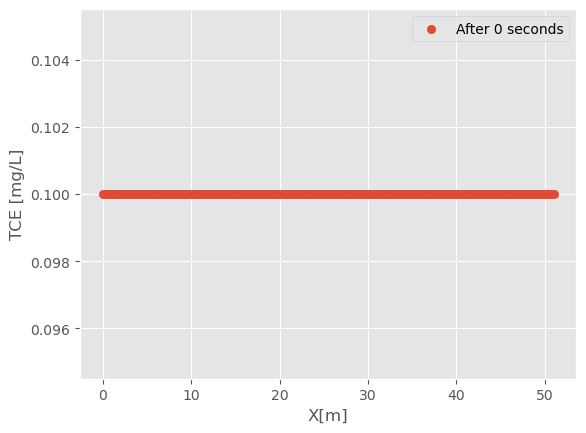

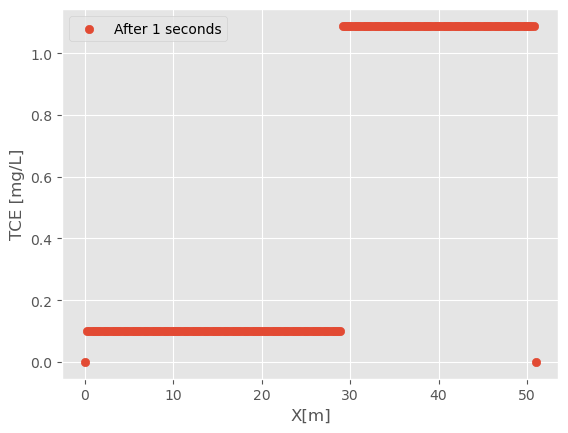

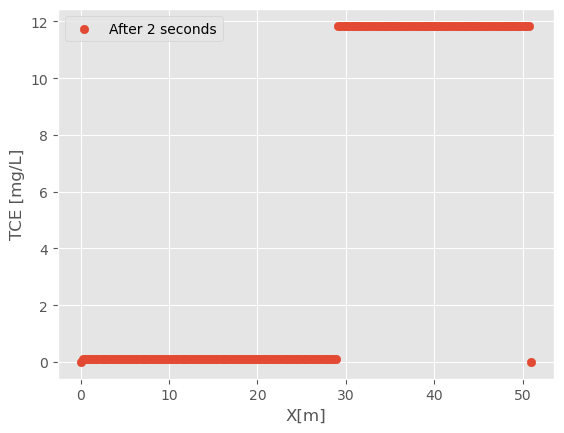

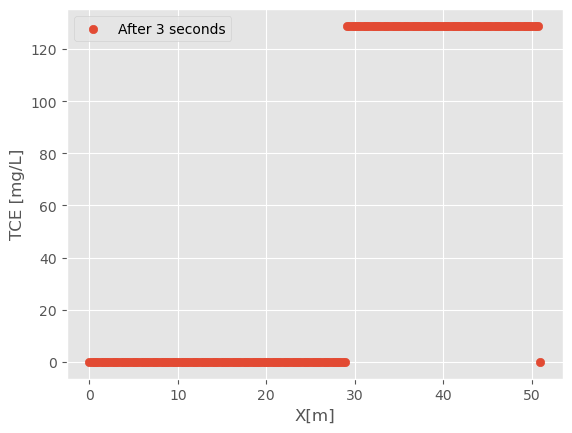

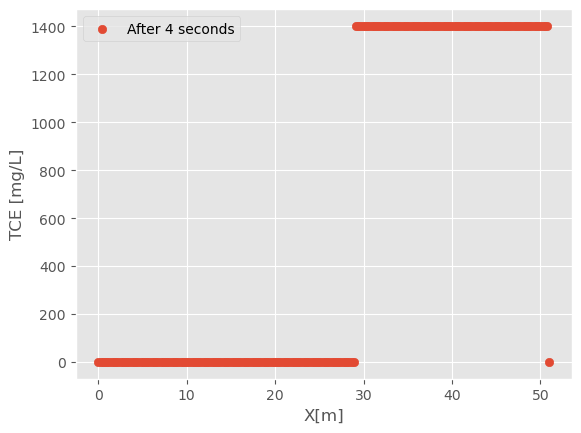

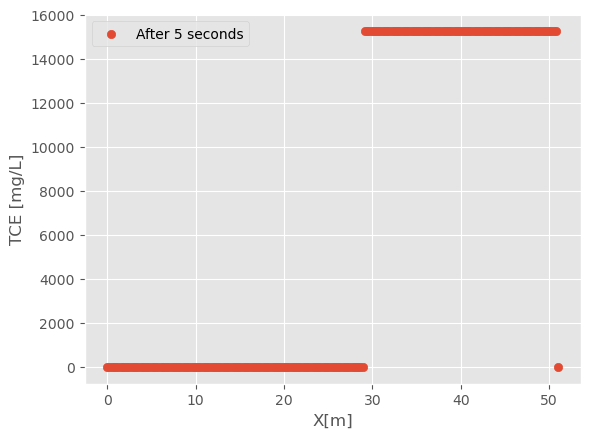

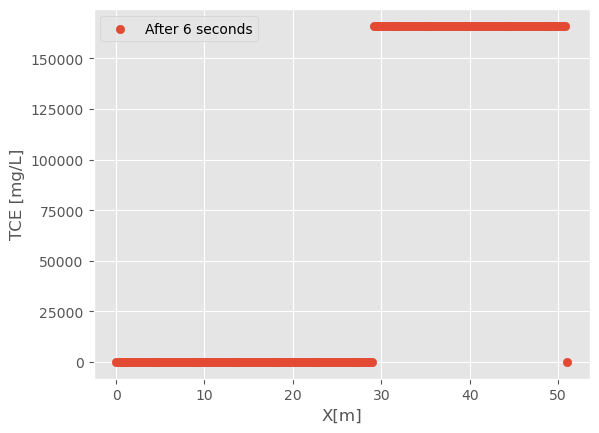

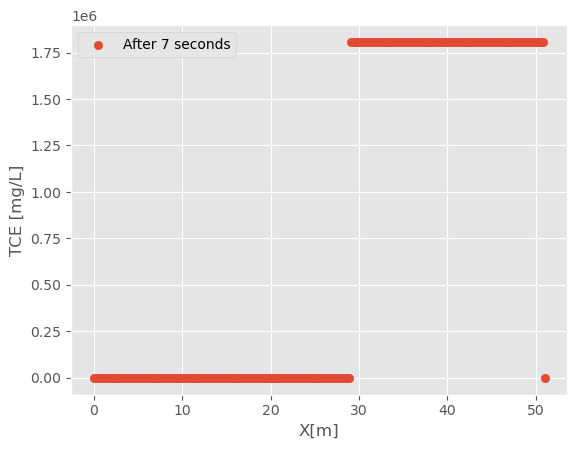

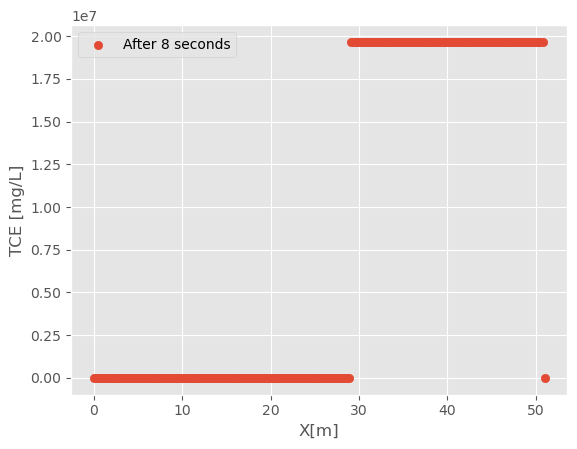

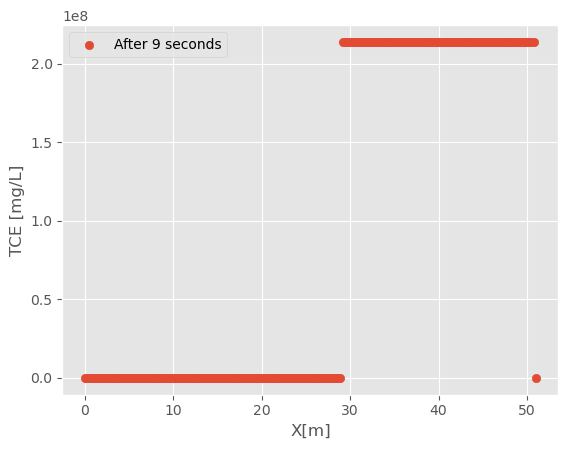

In [24]:
for t in np.arange(10):
    plt.scatter(normalized_x, tce_mat[:, t ], label=f"After {t} seconds")
    plt.xlabel("X[m]")
    plt.ylabel("TCE [mg/L]")
    plt.legend()
    plt.show()

In [ ]:
# Ratio of Ck_spa and Ck_micro

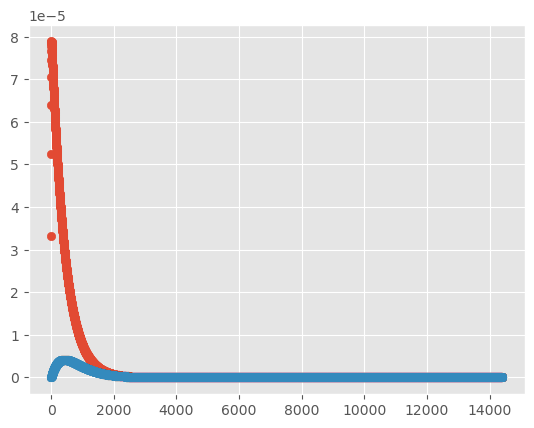

In [150]:
plt.scatter(np.arange(total_time_points), dce_mat[total_grid_points - 2,  :])
plt.scatter(np.arange(total_time_points), vc_mat[total_grid_points - 2,  :])
# plt.scatter(np.arange(total_time_points), tce_mat[total_grid_points - 2,  :]/co_TCE)

plt.show()

In [6]:
L3//delta_x

204.0